In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from tqdm.notebook import tqdm, tnrange
from PIL import Image
import matplotlib.pyplot as plt
import torchsummary
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os

In [2]:
# Set random seed for reproducibility
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

In [3]:
# lfw_dataset = foz.load_zoo_dataset(
#     "lfw",
#     split="train",
#     shuffle=True,
#     seed=0
# )
# load data from local
lfw_dataset = fo.Dataset.from_dir(
    dataset_dir='/home/ichitu/fiftyone/lfw/lfw_funneled',
    dataset_type=fo.types.dataset_types.ImageClassificationDirectoryTree,
    name='lfw_funneled',
    overwrite=True,
    
)


 100% |█████████████| 13233/13233 [3.6s elapsed, 0s remaining, 3.6K samples/s]      


In [4]:
DIM = 224

In [5]:
class LFWDataset:
    def __init__(self, dataset, dim=DIM):
        self.dataset = dataset
        self.filepaths = list(dataset.values("filepath"))
        self.dim = dim
    
    def __len__(self):
        return len(self.filepaths)
    
    def preprocess(self, image, dim):
        image = image.resize((dim, dim))
        return image
    
    def image_path(self, idx):
        return self.filepaths[idx]
    
    def __getitem__(self, idx):
        impath = self.filepaths[idx]
        sample = self.dataset[impath]
        image = Image.open(impath).convert("RGB")
        image = self.preprocess(image, self.dim)
        image = np.array(image)
        label = sample["ground_truth"]["label"]
        return image, label
    
full_dataset = LFWDataset(lfw_dataset, dim=DIM)
print(full_dataset.image_path(7))

/home/ichitu/fiftyone/lfw/lfw_funneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg


In [6]:
def parse_fglfw_pairs(file_path, dataset_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f.readlines()]

    sets = []
    idx = 0
    # Each set has 600 lines for matched (300 pairs) and 600 lines for mismatched (300 pairs)
    for _ in range(10):
        matched = []
        mismatched = []
        # Read 300 matched pairs (2 lines each)
        for i in range(300):
            # add dataset path to image paths
            matched.append((os.path.join(dataset_path, lines[idx + 2*i]), os.path.join(dataset_path, lines[idx + 2*i + 1])))
        idx += 600
        # Read 300 mismatched pairs (2 lines each)
        for i in range(300):
            # add dataset path to image paths
            mismatched.append((os.path.join(dataset_path, lines[idx + 2*i]), os.path.join(dataset_path, lines[idx + 2*i + 1])))
        idx += 600
        sets.append({"matched": matched, "mismatched": mismatched})

    return sets

In [7]:
file_path = "/home/ichitu/fiftyone/lfw/lfw_funneled/pair_FGLFW.txt"
pairs = parse_fglfw_pairs(file_path, "/home/ichitu/fiftyone/lfw/lfw_funneled")
print("Parsed", len(pairs), "sets.")
print("Each set has:", len(pairs[0]["matched"]), "matched pairs and", len(pairs[0]["mismatched"]), "mismatched pairs.")

Parsed 10 sets.
Each set has: 300 matched pairs and 300 mismatched pairs.


### Generating batches with anchor, positive and negative

In [8]:
def batch_generator(dataset, pairs, batch_size, dim=DIM, dataset_path="/home/ichitu/fiftyone/lfw/lfw_funneled"):
    dataset_size = len(dataset)
    if dataset_size < batch_size:
        raise ValueError("Dataset size is smaller than the batch size. \
                         Cannot generate batches.")
    
    anchors_positives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
               [""] * batch_size]
    positives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    anchors_negatives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    negatives = [np.zeros((batch_size, dim, dim, 3), dtype=np.float32), 
                 [""] * batch_size]
    while True:
        for i in range(batch_size):
            # Select a random set
            set_ = random.choice(pairs)
            # Select a random matched pair
            matched_pair = random.choice(set_["matched"])
            # Select a random mismatched pair
            mismatched_pair = random.choice(set_["mismatched"])
            # Load the images
            anchor_positive = Image.open(matched_pair[0]).convert("RGB")
            positive = Image.open(matched_pair[1]).convert("RGB")
            anchors_negative = Image.open(mismatched_pair[0]).convert("RGB")
            negative = Image.open(mismatched_pair[1]).convert("RGB")
            # Preprocess the images
            anchor_positive = anchor_positive.resize((dim, dim))
            positive = positive.resize((dim, dim))
            anchors_negative = anchors_negative.resize((dim, dim))
            negative = negative.resize((dim, dim))
            # Convert to numpy arrays
            anchor_positive = np.array(anchor_positive)
            positive = np.array(positive)
            anchors_negative = np.array(anchors_negative)
            negative = np.array(negative)
            # Add to the batch
            anchors_positives[0][i] = anchor_positive
            anchors_positives[1][i] = matched_pair[0]
            positives[0][i] = positive
            positives[1][i] = matched_pair[1]
            anchors_positives[0][i] = anchor_positive / 255.
            anchors_positives[1][i] = matched_pair[0].replace(dataset_path + "/","").split("/")[0]
            positives[0][i] = positive / 255.
            positives[1][i] = matched_pair[1].replace(dataset_path + "/","").split("/")[0]
            anchors_negatives[0][i] = anchors_negative / 255.
            anchors_negatives[1][i] = mismatched_pair[0].replace(dataset_path + "/","").split("/")[0]
            negatives[0][i] = negative / 255.
            negatives[1][i] = mismatched_pair[1].replace(dataset_path + "/","").split("/")[0]
        yield [anchors_positives, positives, anchors_negatives, negatives]
        


In [9]:
def batch_generator3(dataset, batch_size, dim=DIM):
    dataset_size = len(dataset)
    if dataset_size < batch_size:
        raise ValueError("Dataset size is smaller than the batch size. \
                         Cannot generate batches.")
    
    anchors = [np.zeros((batch_size, DIM, DIM, 3), dtype=np.float32), 
               [""] * batch_size]
    positives = [np.zeros((batch_size, DIM, DIM, 3), dtype=np.float32), 
                 [""] * batch_size]
    negatives = [np.zeros((batch_size, DIM, DIM, 3), dtype=np.float32), 
                 [""] * batch_size]

    while True:
        for i in range(batch_size):
            if len(dataset) <= 0:  # Check if the dataset is exhausted
                return  # Stop the generator if the dataset is empty
            anchor_idx = np.random.randint(len(dataset))
            anchor, label = dataset[anchor_idx]
            positive_indices = np.where(np.array(dataset.dataset.values(
                "ground_truth.label")) == label)[0]
            negative_indices = np.where(np.array(dataset.dataset.values(
                "ground_truth.label")) != label)[0]
            if len(positive_indices) == 0 or len(negative_indices) == 0:  
                # Check if no valid pairs are available
                continue
            positive_idx = np.random.choice(positive_indices)
            negative_idx = np.random.choice(negative_indices)
            positive, positive_label = dataset[positive_idx]
            negative, negative_label = dataset[negative_idx]

            anchors[0][i] = anchor
            anchors[1][i] = label
            positives[0][i] = positive
            positives[1][i] = positive_label
            negatives[0][i] = negative
            negatives[1][i] = negative_label

        yield anchors, positives, negatives


Testing what the generator does

In [10]:
BS = 1
generator = batch_generator(full_dataset, pairs, BS)

['Carlos_Menem']
['Carlos_Menem']
['Jeb_Bush']
['Timothy_Rigas']


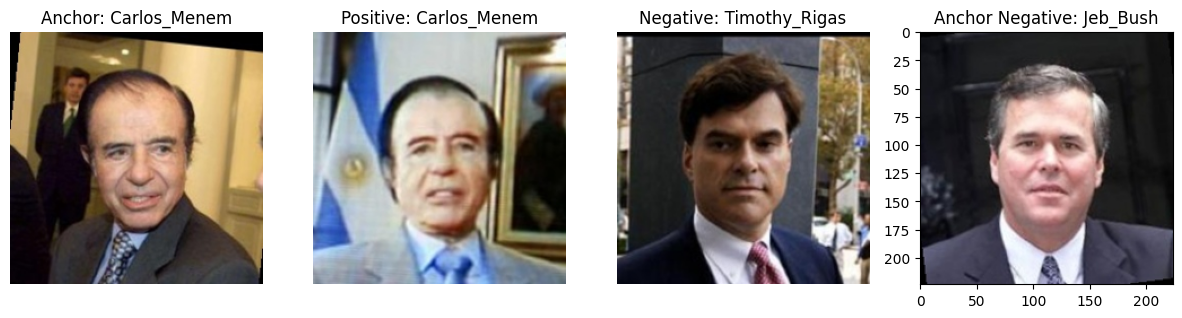

In [11]:
# Get a batch of data
batch = next(generator)
anchor = batch[0]
positive = batch[1]
anchor_negative = batch[2]
negative = batch[3]
print(anchor[1])
print(positive[1])
print(anchor_negative[1])
print(negative[1])
for i in range(BS):
    fig, ax = plt.subplots(1, 4, figsize=(15, 15))
    ax[0].imshow(anchor[0][i])
    ax[0].set_title("Anchor:" + " " + anchor[1][i])
    ax[0].axis("off")
    ax[1].imshow(positive[0][i])
    ax[1].set_title("Positive:" + " " + positive[1][i])
    ax[1].axis("off")
    ax[2].imshow(negative[0][i])
    ax[2].set_title("Negative:" + " " + negative[1][i])
    ax[2].axis("off")
    ax[3].imshow(anchor_negative[0][i])
    ax[3].set_title("Anchor Negative:" + " " + anchor_negative[1][i])
    plt.show()

# Model


In [12]:
class FaceRecZF(nn.Module):
    def __init__(self, input_shape = (3, 220, 220)):
        super(FaceRecZF, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.rnorm1 = nn.LocalResponseNorm(size=1)
        self.conv2a = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
        self.rnorm2 = nn.LocalResponseNorm(size=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv3a = nn.Conv2d(in_channels=192, out_channels=192, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv4a = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=1, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5a = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6a = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.concat = nn.Flatten()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc7132 = nn.Linear(128, 128)

    def L2Norm(self, x):
        return F.normalize(x, p=2, dim=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.rnorm1(x)
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2(x))
        x = self.rnorm2(x)
        x = self.pool2(x)
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4a(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5a(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6a(x))
        x = F.relu(self.conv6(x))
        x = self.pool4(x)
        # x = self.concat(x)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc7132(x)
        return x
    

In [13]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = FaceRecZF().to(device)
# torchsummary.summary(model, (3, 220, 220))

In [14]:
class FaceRecInception(nn.Module):
    def __init__(self, input_shape=(3, 220, 220)):
        super(FaceRecInception, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.rnorm1 = nn.LocalResponseNorm(size=1)
        
        # Inception Module 1
        def inception_block1(in_channels, out_channels):
            conv3x3_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv3x3 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=3, padding=1)
            return nn.Sequential(
                conv3x3_reduce,
                nn.ReLU(),
                conv3x3,
                nn.ReLU()
            )    
        self.inception1 = inception_block1(64, [64, 192])

        self.rnorm2 = nn.LocalResponseNorm(size=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Modules 1x1, 3x3, 5x5, and Pooling
        def inception_block1x1(in_channels, out_channels):
            conv1x1 = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            return nn.Sequential(
                conv1x1,
                nn.ReLU()
            )
        def inception_block3x3(in_channels, out_channels, stride=1):
            conv3x3_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv3x3 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=3, padding=1, stride=stride)
            return nn.Sequential(
                conv3x3_reduce,
                nn.ReLU(),
                conv3x3,
                nn.ReLU()
            )
        def inception_block5x5(in_channels, out_channels, stride=1):
            conv5x5_reduce = nn.Conv2d(in_channels, out_channels[0], kernel_size=1)
            conv5x5 = nn.Conv2d(out_channels[0], out_channels[1], kernel_size=5, padding=2, stride=stride)
            return nn.Sequential(
                conv5x5_reduce,
                nn.ReLU(),
                conv5x5,
                nn.ReLU()
            )
        
        class L2Pooling(nn.Module):
            def __init__(self):
                super(L2Pooling, self).__init__()
            def forward(self, x):
                return torch.sqrt(F.avg_pool2d(x**2, kernel_size=3, stride=1, padding=1))

        def pool_proj(in_channels, out_channels, max_pool=True):
            if max_pool:
                return nn.Sequential(
                    nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1),
                    nn.ReLU()
                   )
            else:
                return nn.Sequential(
                    L2Pooling(),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1),
                    nn.ReLU()
                )
        
        # Inception Module 3a
        self.inception3a1x1 = inception_block1x1(192, [64])
        self.inception3a3x3 = inception_block3x3(192, [96, 128])
        self.inception3a5x5 = inception_block5x5(192, [16, 32])
        self.inception3apool = pool_proj(192, 32, max_pool=True)

        # Inception Module 3b
        self.inception3b1x1 = inception_block1x1(256, [64])
        self.inception3b3x3 = inception_block3x3(256, [96, 128])
        self.inception3b5x5 = inception_block5x5(256, [32, 64])
        self.inception3bpool = pool_proj(256, 64, max_pool=False)

        # Inception Module 3c
        self.inception3c3x3 = inception_block3x3(320, [128, 256], stride=2)
        self.inception3c5x5 = inception_block5x5(320, [32, 64], stride=2)
        self.inception3cpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Module 4a
        self.inception4a1x1 = inception_block1x1(640, [256])
        self.inception4a3x3 = inception_block3x3(640, [96, 192])
        self.inception4a5x5 = inception_block5x5(640, [32, 64])
        self.inception4apool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4b
        self.inception4b1x1 = inception_block1x1(640, [DIM])
        self.inception4b3x3 = inception_block3x3(640, [112, DIM])
        self.inception4b5x5 = inception_block5x5(640, [32, 64])
        self.inception4bpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4c
        self.inception4c1x1 = inception_block1x1(640, [192])
        self.inception4c3x3 = inception_block3x3(640, [128, 256])
        self.inception4c5x5 = inception_block5x5(640, [32, 64])
        self.inception4cpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4d
        self.inception4d1x1 = inception_block1x1(640, [160])
        self.inception4d3x3 = inception_block3x3(640, [144, 288])
        self.inception4d5x5 = inception_block5x5(640, [32, 64])
        self.inception4dpool = pool_proj(640, 128, max_pool=False)

        # Inception Module 4e
        self.inception4e3x3 = inception_block3x3(640, [160, 256], stride=2)
        self.inception4e5x5 = inception_block5x5(640, [64, 128], stride=2)
        self.inception4epool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception Module 5a
        self.inception5a1x1 = inception_block1x1(1024, [384])
        self.inception5a3x3 = inception_block3x3(1024, [192, 384])
        self.inception5a5x5 = inception_block5x5(1024, [48, 128])
        self.inception5apool = pool_proj(1024, 128, max_pool=False)

        # Inception Module 5b
        self.inception5b1x1 = inception_block1x1(1024, [384])
        self.inception5b3x3 = inception_block3x3(1024, [192, 384])
        self.inception5b5x5 = inception_block5x5(1024, [48, 128])
        self.inception5bpool = pool_proj(1024, 128, max_pool=True)

        # Final Pooling and Fully Connected Layer
        self.avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc1 = nn.Linear(1024, 128)

        # L2 Normalization
        def L2Norm(x):
            return F.normalize(x, p=2, dim=1)
        self.L2Norm = L2Norm

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.rnorm1(x)
        x = self.inception1(x)
        x = self.rnorm2(x)
        x = self.max_pool2(x)

        # Inception Module 3a
        inception3a1x1 = self.inception3a1x1(x)
        inception3a3x3 = self.inception3a3x3(x)
        inception3a5x5 = self.inception3a5x5(x)
        inception3apool = self.inception3apool(x)
        x = torch.cat([inception3a1x1, inception3a3x3, inception3a5x5, inception3apool], 1)

        # Inception Module 3b
        inception3b1x1 = self.inception3b1x1(x)
        inception3b3x3 = self.inception3b3x3(x)
        inception3b5x5 = self.inception3b5x5(x)
        inception3bpool = self.inception3bpool(x)
        x = torch.cat([inception3b1x1, inception3b3x3, inception3b5x5, inception3bpool], 1)

        # Inception Module 3c
        inception3c3x3 = self.inception3c3x3(x)
        inception3c5x5 = self.inception3c5x5(x)
        inception3cpool = self.inception3cpool(x)
        x = torch.cat([inception3c3x3, inception3c5x5, inception3cpool], 1)

        # Inception Module 4a
        inception4a1x1 = self.inception4a1x1(x)
        inception4a3x3 = self.inception4a3x3(x)
        inception4a5x5 = self.inception4a5x5(x)
        inception4apool = self.inception4apool(x)
        x = torch.cat([inception4a1x1, inception4a3x3, inception4a5x5, inception4apool], 1)

        # Inception Module 4b
        inception4b1x1 = self.inception4b1x1(x)
        inception4b3x3 = self.inception4b3x3(x)
        inception4b5x5 = self.inception4b5x5(x)
        inception4bpool = self.inception4bpool(x)
        x = torch.cat([inception4b1x1, inception4b3x3, inception4b5x5, inception4bpool], 1)

        # Inception Module 4c
        inception4c1x1 = self.inception4c1x1(x)
        inception4c3x3 = self.inception4c3x3(x)
        inception4c5x5 = self.inception4c5x5(x)
        inception4cpool = self.inception4cpool(x)
        x = torch.cat([inception4c1x1, inception4c3x3, inception4c5x5, inception4cpool], 1)

        # Inception Module 4d
        inception4d1x1 = self.inception4d1x1(x)
        inception4d3x3 = self.inception4d3x3(x)
        inception4d5x5 = self.inception4d5x5(x)
        inception4dpool = self.inception4dpool(x)
        x = torch.cat([inception4d1x1, inception4d3x3, inception4d5x5, inception4dpool], 1)

        # Inception Module 4e
        inception4e3x3 = self.inception4e3x3(x)
        inception4e5x5 = self.inception4e5x5(x)
        inception4epool = self.inception4epool(x)
        x = torch.cat([inception4e3x3, inception4e5x5, inception4epool], 1)

        # Inception Module 5a
        inception5a1x1 = self.inception5a1x1(x)
        inception5a3x3 = self.inception5a3x3(x)
        inception5a5x5 = self.inception5a5x5(x)
        inception5apool = self.inception5apool(x)
        x = torch.cat([inception5a1x1, inception5a3x3, inception5a5x5, inception5apool], 1)

        # Inception Module 5b
        inception5b1x1 = self.inception5b1x1(x)
        inception5b3x3 = self.inception5b3x3(x)
        inception5b5x5 = self.inception5b5x5(x)
        inception5bpool = self.inception5bpool(x)
        x = torch.cat([inception5b1x1, inception5b3x3, inception5b5x5, inception5bpool], 1)

        # Final Pooling and Fully Connected Layer
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        # L2 Normalization
        x = self.L2Norm(x)
        return x

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_inception = FaceRecInception().to(device)
# print(model)
torchsummary.summary(model_inception, (3, DIM, DIM))
# export as onnx
dummy_input = torch.randn(1, 3, DIM, DIM).to(device)

torch.onnx.export(model_inception, dummy_input, "face_rec_inception.onnx", verbose=False,
                  opset_version=9, input_names=["input"], output_names=["output"])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
 LocalResponseNorm-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]           4,160
              ReLU-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 192, 56, 56]         110,784
              ReLU-7          [-1, 192, 56, 56]               0
 LocalResponseNorm-8          [-1, 192, 56, 56]               0
         MaxPool2d-9          [-1, 192, 28, 28]               0
           Conv2d-10           [-1, 64, 28, 28]          12,352
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 96, 28, 28]          18,528
             ReLU-13           [-1, 96, 28, 28]               0
           Conv2d-14          [-1, 128,

/home/ichitu/machine-learning/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:1173: UserWarning: This model contains a squeeze operation on dimension 1. If the model is intended to be used with dynamic input shapes, please use opset version 11 to export the model.
  warnings.warn(


In [16]:
# get the number of FLOPs and number of parameters
import torch.profiler

model = FaceRecInception().to(device)
model.eval()
inputs = torch.randn(100, 3, DIM, DIM).to(device)
# Use the profiler to estimate FLOPS
with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    with_flops=True
    ) as prof:
    model(inputs)

# Print the profiling results
print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=-1))


OutOfMemoryError: CUDA out of memory. Tried to allocate 308.00 MiB. GPU 0 has a total capacity of 15.63 GiB of which 253.31 MiB is free. Process 1309788 has 14.72 GiB memory in use. Including non-PyTorch memory, this process has 646.00 MiB memory in use. Of the allocated memory 430.13 MiB is allocated by PyTorch, and 7.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [17]:
from fvcore.nn import FlopCountAnalysis

flops = FlopCountAnalysis(model, inputs)
print(f"FLOPs: {flops.total()/1e9:.2f} G")

Unsupported operator aten::max_pool2d encountered 6 time(s)


Unsupported operator aten::mul encountered 4 time(s)


Unsupported operator aten::pad encountered 2 time(s)


Unsupported operator aten::avg_pool3d encountered 2 time(s)


Unsupported operator aten::add encountered 2 time(s)


Unsupported operator aten::pow encountered 8 time(s)


Unsupported operator aten::div encountered 3 time(s)


Unsupported operator aten::avg_pool2d encountered 7 time(s)


Unsupported operator aten::sqrt encountered 6 time(s)


Unsupported operator aten::linalg_vector_norm encountered 1 time(s)


Unsupported operator aten::clamp_min encountered 1 time(s)


Unsupported operator aten::expand_as encountered 1 time(s)


FLOPs: 159.65 G


In [18]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor, negative)
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin))
    return loss

In [19]:
def train_triplet_loss(model, generator, optimizer, device, epochs=1, bathes_per_epoch=100):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, device_ids=[0,1,2]).to(device)
    model.train()
    for epoch in tnrange(epochs, desc="Epochs"):
        running_loss = 0.0
        for i, data in enumerate(tqdm(generator, total=bathes_per_epoch, desc="Batches", leave=False)):
            anchors, positives, negatives = data
            anchors = torch.tensor(anchors[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            optimizer.zero_grad()
            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)
            loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i >= bathes_per_epoch:
                break
        print(f"Epoch {epoch+1}, Loss: {running_loss/(i+1)}")
    print("Finished Training")
    return model

In [20]:
def quartet_loss(anchor, positive, negative, anchor_negative, margin=0.2):
    distance_positive = F.pairwise_distance(anchor, positive)
    distance_negative = F.pairwise_distance(anchor, negative)
    distance_anchor_negative = F.pairwise_distance(anchor, anchor_negative)
    loss = torch.mean(F.relu(distance_positive - distance_negative + margin)) + torch.mean(F.relu(distance_positive - distance_anchor_negative + margin))
    return loss

In [21]:
def train_quartet_loss(model, generator, optimizer, device, epochs=25, bathes_per_epoch=100):
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model, device_ids=[0,1,2]).to(device)
    model.train()
    train_losses = []
    for epoch in tnrange(epochs, desc="Epochs"):
        running_loss = 0.0
        for i, data in zip(tnrange(bathes_per_epoch, desc="Batches", leave=False), generator):
            anchors_positives, positives, anchors_negatives, negatives = data
            anchors_positives = torch.tensor(anchors_positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            optimizer.zero_grad()
            anchor_positive_embeddings = model(anchors_positives)
            positive_embeddings = model(positives)
            anchor_negative_embeddings = model(anchors_negatives)
            negative_embeddings = model(negatives)
            loss = quartet_loss(anchor_positive_embeddings, positive_embeddings, negative_embeddings, anchor_negative_embeddings)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        print(f"Epoch {epoch+1}, Loss: {running_loss/(i+1)}")
        train_losses.append(running_loss/(i+1))
    print("Finished Training")
    return model, train_losses

In [22]:
# optimizer = optim.SGD(model_inception.parameters(), lr=0.005)
# generator = batch_generator(train_dataset, 256)
# model_inception = train_triplet_loss(model_inception, generator, optimizer, device, epochs=10, bathes_per_epoch=20)

In [23]:
optimizer = optim.SGD(model_inception.parameters(), lr=0.005)
generator = batch_generator(full_dataset, pairs, 256)
model_inception, train_losses = train_quartet_loss(model_inception, generator, optimizer, device, epochs=2, bathes_per_epoch=2)

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, Loss: 0.3999986797571182


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2, Loss: 0.39999814331531525
Finished Training


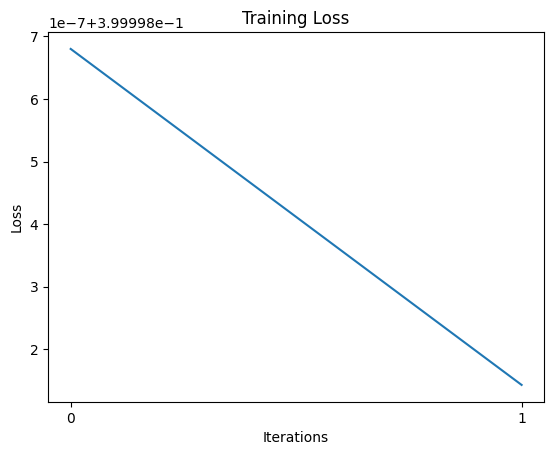

In [24]:
# plot the training loss
ax = plt.figure().gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
ax.plot(train_losses)

In [25]:
# Save the model with timestamp and dimension
tmstmp = time.strftime("%Y%m%d-%H%M%S")
torch.save(model_inception.state_dict(), "{}face_recognition_inception_better_pairing{}.pt".format(DIM, tmstmp))

# clean cuda memory
torch.cuda.empty_cache()

In [93]:
def evaluate3(model, generator, device, batches):
    model.eval()
    tabel_data = "| Anchor - Positive | Anchor - Negative |\n" +\
                 "|" + 19*"-" + "+" + 19*"-" + "|"
        
    with torch.no_grad():
        for i, data in zip(tnrange(batches, desc="Batches", leave=False), generator):
            anchors, positives, negatives,_ = data
            anchors = torch.tensor(anchors[0], device=device, dtype=torch.float32)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32)

            anchors = torch.transpose(anchors, 1, 3)
            positives = torch.transpose(positives, 1, 3)
            negatives = torch.transpose(negatives, 1, 3)
            # print(anchors.shape, positives.shape, negatives.shape)

            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)
            distance_positive = F.pairwise_distance(anchor_embeddings, positive_embeddings)
            distance_negative = F.pairwise_distance(anchor_embeddings, negative_embeddings)

            # print the distances in a table
            if i == 0:
                print(tabel_data)
            for j in range(len(anchors)):
                tabel_data = f"| {distance_positive[j]:.15f} | {distance_negative[j]:.15f} |"
                print(tabel_data)

In [27]:
def evaluate(model, generator, device, batches):
    model.eval()
    tabel_data = "| Anchor - Positive | Anchor - Negative |\n" +\
                 "|" + 19*"-" + "+" + 19*"-" + "|"
        
    with torch.no_grad():
        for i, data in zip(tqdm(range(batches), desc="Batches", leave=False), generator):
            anchors_positives, positives, anchors_negatives, negatives = data
            anchors_positives = torch.tensor(anchors_positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            positives = torch.tensor(positives[0], device=device, dtype=torch.float32).transpose(1, 3)
            anchors_negatives = torch.tensor(anchors_negatives[0], device=device, dtype=torch.float32).transpose(1, 3)
            negatives = torch.tensor(negatives[0], device=device, dtype=torch.float32).transpose(1, 3)

            anchor_positive_embeddings = model(anchors_positives)
            positive_embeddings = model(positives)
            anchor_negative_embeddings = model(anchors_negatives)
            negative_embeddings = model(negatives)
            distance_positive = F.pairwise_distance(anchor_positive_embeddings, positive_embeddings)
            distance_negative = F.pairwise_distance(anchor_positive_embeddings, negative_embeddings)
            distance_anchor_negative = F.pairwise_distance(anchor_positive_embeddings, anchor_negative_embeddings)

            # print the distances in a table
            if i == 0:
                print(tabel_data)
            for j in range(len(anchors_positives)):
                tabel_data = f"| {distance_positive[j]:.15f} | {distance_negative[j]:.15f} |"
                print(tabel_data)
            



In [18]:
generator = batch_generator(full_dataset, pairs, 256)
model_inception = FaceRecInception().to(device)
state_dict = torch.load("{}face_recognition_inception_better_pairing{}.pt".format(DIM, tmstmp), weights_only=True)
# Remove 'module.' prefix from keys if present
state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model_inception.load_state_dict(state_dict=state_dict)
evaluate(model_inception, generator, device, batches=2)

NameError: name 'tmstmp' is not defined

In [135]:
model_inception = FaceRecInception().to(device)
tmstmp = "20250115-215326"
state_dict = torch.load("{}face_recognition_inception{}.pt".format(DIM, tmstmp), weights_only=True)
state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model_inception.load_state_dict(state_dict=state_dict)
evaluate3(model_inception, generator, device, batches=2)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

| Anchor - Positive | Anchor - Negative |
|-------------------+-------------------|
| 0.000015319606973 | 0.000017816077161 |
| 0.000013901246348 | 0.000013900878002 |
| 0.000013170541024 | 0.000020369445338 |
| 0.000020030984160 | 0.000015237272237 |
| 0.000015777515728 | 0.000021641259082 |
| 0.000015312647520 | 0.000019573792088 |
| 0.000022320911739 | 0.000028089951229 |
| 0.000013664541257 | 0.000015169153812 |
| 0.000016180480088 | 0.000016615398636 |
| 0.000016140420485 | 0.000023146583771 |
| 0.000013816982573 | 0.000019568928110 |
| 0.000013317511730 | 0.000018555481802 |
| 0.000016909771148 | 0.000014141694919 |
| 0.000025879071472 | 0.000014413539247 |
| 0.000016382322428 | 0.000020085308279 |
| 0.000020983288778 | 0.000020930205210 |
| 0.000014886389181 | 0.000014776513126 |
| 0.000013473740182 | 0.000012680771761 |
| 0.000019595758204 | 0.000014406021364 |
| 0.000012286797755 | 0.000017115322407 |
| 0.000014724236280 | 0.000015167856873 |
| 0.000025924087822 | 0.0000229751

Positive Distance: 2.1277211999404244e-05
 Negative Distance: 1.5564919522148557e-05
  Anchor Negative Distance: 1.5923433238640428e-05


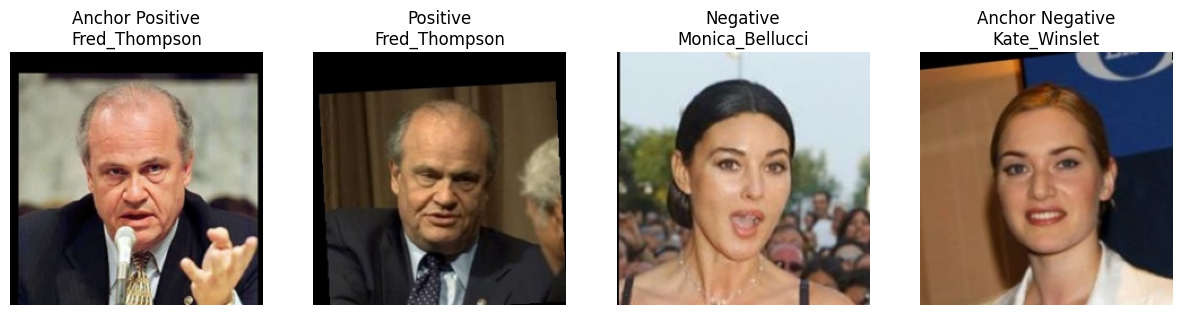

In [141]:
image_generator = batch_generator(full_dataset, pairs, 1)
an_data, pos_data, an_neg_data, neg_data = next(image_generator)
an = torch.tensor(an_data[0], device=device, dtype=torch.float32)
pos = torch.tensor(pos_data[0], device=device, dtype=torch.float32)
neg = torch.tensor(neg_data[0], device=device, dtype=torch.float32)
an_neg = torch.tensor(an_neg_data[0], device=device, dtype=torch.float32)
an_t = torch.transpose(an, 1, 3)
pos_t = torch.transpose(pos, 1, 3)
neg_t = torch.transpose(neg, 1, 3)
an_neg_t = torch.transpose(an_neg, 1, 3)
an_emb = model_inception(an_t)
pos_emb = model_inception(pos_t)
neg_emb = model_inception(neg_t)
an_neg_emb = model_inception(an_neg_t)
distance_positive = F.pairwise_distance(an_emb, pos_emb)
distance_negative = F.pairwise_distance(an_emb, neg_emb)
distance_an_neg = F.pairwise_distance(an_emb, an_neg_emb)
print(f"Positive Distance: {distance_positive.item()}\n Negative Distance: {distance_negative.item()}\n",
      f" Anchor Negative Distance: {distance_an_neg.item()}")
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 4, 1)
ax.imshow(an[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Anchor Positive\n{an_data[1][0]}")
ax = plt.subplot(1, 4, 2)
ax.imshow(pos[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Positive\n{pos_data[1][0]}")
ax = plt.subplot(1, 4, 3)
ax.imshow(neg[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Negative\n{neg_data[1][0]}")
ax = plt.subplot(1, 4, 4)
ax.imshow(an_neg[0].cpu().numpy().transpose(0, 1, 2))
ax.axis("off")
ax.set_title(f"Anchor Negative\n{an_neg_data[1][0]}")
plt.show()


In [133]:

random_samples = foz.load_zoo_dataset(
    "lfw",
    split="test",
    max_samples = 50
)

# Create a dataset from the samples
random_dataset = LFWDataset(random_samples)

Split 'test' already downloaded
Loading existing dataset 'lfw-test-50'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [132]:
def preprocess_image(image):
    image = image.resize((224, 224))
    image = transforms.ToTensor()(image)
    # image = F.normalize(image)
    image = image.unsqueeze(0)
    return image

def get_image(image):
    return Image.fromarray(image)

def get_images(images):
    return [get_image(image) for image in images]

def get_image_from_sample(sample):
    return get_image(np.array(sample[0]))

def get_images_from_samples(samples):
    return [get_image_from_sample(sample) for sample in samples]

print(len(random_dataset))
images = get_images_from_samples(random_dataset)
print(len(images))

13233


KeyboardInterrupt: 

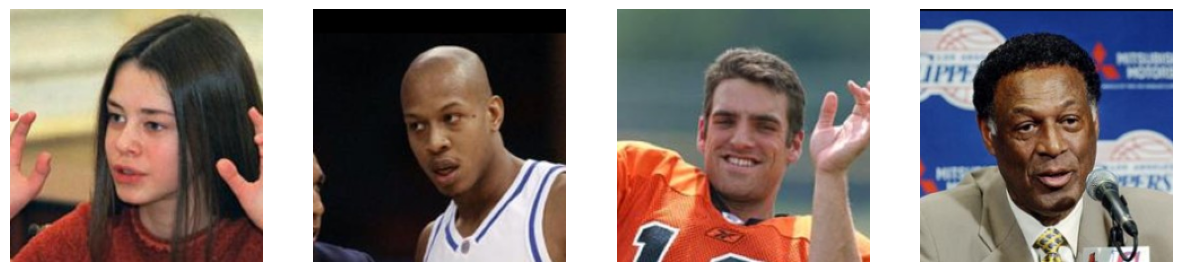

In [119]:
plt.figure(figsize=(15, 15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i])
    plt.axis("off")

In [120]:
def get_embedding(image):
    image = preprocess_image(image)
    # print(image.shape)
    # plt.imshow(image[0])
    # get image on cuda
    image = image.cuda()
    # get embedding
    embedding = model_inception(image)
    return embedding.cpu().detach().numpy()

def get_embeddings(images):
    embeddings = []
    for image in tqdm(images):
       embeddings.append(get_embedding(image))
    return np.array(embeddings)

In [121]:
em = get_embedding(images[3])
print(em.shape)

(1, 128)


In [122]:
embeddings = get_embeddings(images)

  0%|          | 0/50 [00:00<?, ?it/s]

In [123]:
embeddings = embeddings.reshape(embeddings.shape[0], embeddings.shape[2])
print(embeddings.shape)

(50, 128)


In [124]:
results = fob.compute_visualization(
    random_samples,
    embeddings=embeddings,
    label_field="ground_truth.label",
    classes=full_dataset.dataset.classes,
    brain_key="faceNet_embeddings_tsne",
    output_dir="faceNet_embeddings",
    overwrite=True,
    method = "tsne",
    
)

Generating visualization...
[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.000007
[t-SNE] Computed conditional probabilities in 0.001s
[t-SNE] Iteration 50: error = 50.4307823, gradient norm = 0.2945993 (50 iterations in 0.042s)
[t-SNE] Iteration 100: error = 48.2779999, gradient norm = 0.2786045 (50 iterations in 0.004s)
[t-SNE] Iteration 150: error = 46.9324036, gradient norm = 0.4027779 (50 iterations in 0.004s)
[t-SNE] Iteration 200: error = 46.2728958, gradient norm = 0.4545716 (50 iterations in 0.004s)
[t-SNE] Iteration 250: error = 50.1303139, gradient norm = 0.1940037 (50 iterations in 0.005s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.130314
[t-SNE] Iteration 300: error = 0.9731442, gradient norm = 0.0045600 (50 iterations in 0.004s)
[t-SNE] Iteration 350: error = 0.8235735, gra

/home/ichitu/machine-learning/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [125]:
# select 50 random samples


sess = fo.launch_app(dataset=random_samples, port=10100)
sess.open_tab()

<IPython.core.display.Javascript object>